# Maximización de $f(x) = x\sin(10\pi x) + 1$ en $[0,1]$  

Este notebook contiene un **procedimiento numérico y justificativo** para encontrar el máximo global de la función
\(f(x)=x\sin(10\pi x)+1\) en el intervalo \([0,1]\). Se utiliza:

1. Muestreo en una grilla fina para localizar candidatos.  
2. Detección de máximos locales en la grilla.  
3. Refinamiento de las raíces de la derivada $f'(x)=0$ usando el método de Newton (derivadas analíticas).  
4. Evaluación de candidatos y extremos para seleccionar el máximo global.  

Los bloques de código que siguen implementan exactamente este flujo y muestran la gráfica final.

In [1]:
import numpy as np
def f(x):
    x = np.asarray(x)
    return x * np.sin(10*np.pi*x) + 1

def f1(x):
    return np.sin(10*np.pi*x) + 10*np.pi*x*np.cos(10*np.pi*x)

def f2(x):
    return 20*np.pi*np.cos(10*np.pi*x) - 100*(np.pi**2)*x*np.sin(10*np.pi*x)

# Muestreo y cálculo en grilla
N = 20001
x_grid = np.linspace(0,1,N)
f_grid = f(x_grid)

# (El resto del flujo sigue: detección de máximos locales, refinamiento con Newton y evaluación final)

## Muestreo para localizar candidatos
Se toma una grilla uniforme en [0,1] y se evalúa la función para localizar máximos locales.

In [2]:
# Muestreo y detección de máximos locales
idx_max = int(np.argmax(f_grid))
x0 = x_grid[idx_max]
local_max_idx = np.where((f_grid[1:-1] > f_grid[:-2]) & (f_grid[1:-1] > f_grid[2:]))[0] + 1
candidates = list(x_grid[local_max_idx])
if idx_max not in x_grid[local_max_idx]:
    candidates.append(x0)
cand_vals = [(x, float(f(x))) for x in candidates]
cand_vals_sorted = sorted(cand_vals, key=lambda t: t[1], reverse=True)
top_candidates = [t[0] for t in cand_vals_sorted[:10]]
top_candidates


[np.float64(0.8512000000000001),
 np.float64(0.8512000000000001),
 np.float64(0.6515500000000001),
 np.float64(0.45225000000000004),
 np.float64(0.25395),
 np.float64(0.0646)]

## Refinamiento de las raíces de la derivada
Se usa el método de Newton (derivadas analíticas) para refinar las posiciones de los máximos locales detectados.

In [3]:
def newton_refine(x0, tol=1e-14, maxiter=200):
    x = float(np.clip(x0, 0.0, 1.0))
    for i in range(maxiter):
        fp = f1(x)
        fpp = f2(x)
        if abs(fpp) < 1e-16:
            break
        dx = fp / fpp
        if abs(dx) > 0.2:
            dx = np.sign(dx)*0.2
        x_new = x - dx
        x_new = min(1.0, max(0.0, x_new))
        if abs(x_new - x) < tol:
            x = x_new
            break
        x = x_new
    return x

roots = []
for xinit in top_candidates:
    xr = newton_refine(xinit)
    xr = float(np.clip(xr, 0.0, 1.0))
    roots.append(xr)

# Deduplicación
roots_unique = []
for r in roots:
    if not any(abs(r - ru) < 1e-10 for ru in roots_unique):
        roots_unique.append(r)
roots_unique = sorted(roots_unique)
roots_unique


[0.06457736765434056,
 0.2539688174816772,
 0.4522367566959015,
 0.651553834624343,
 0.8511897933117254]

## Evaluación final y gráfica
Se evalúan las raíces refinadas y los extremos; se elige el máximo global y se grafica la función con la marca del máximo.

Máximo global aproximado: x* = 0.851189793312
f(x*) = 1.850595242963


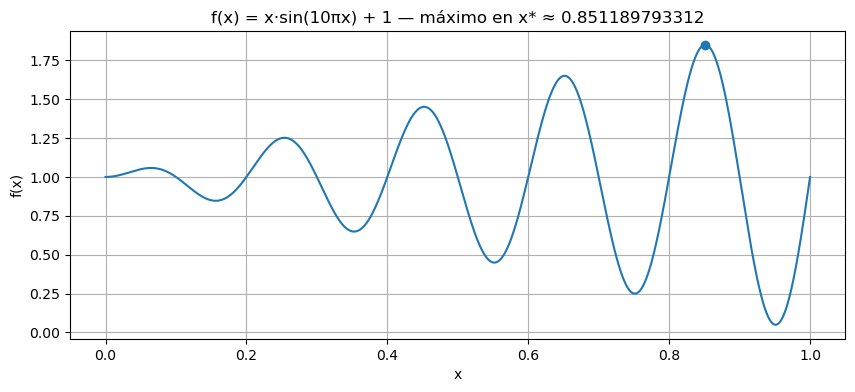

In [4]:
all_points = roots_unique + [0.0, 1.0]
evals = [(x, float(f(x))) for x in all_points]
x_star, f_star = max(evals, key=lambda t: t[1])
print('Máximo global aproximado: x* = {:.12f}'.format(x_star))
print('f(x*) = {:.12f}'.format(f_star))

import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(x_grid, f_grid)
plt.scatter([x_star], [f_star])
plt.title('f(x) = x·sin(10πx) + 1 — máximo en x* ≈ {:.12f}'.format(x_star))
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()


Máximo aproximado: x* = 0.860578, f(x*) = 1.813492


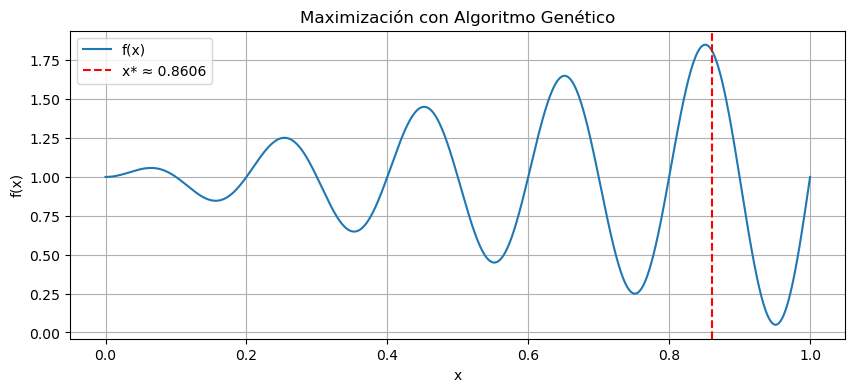

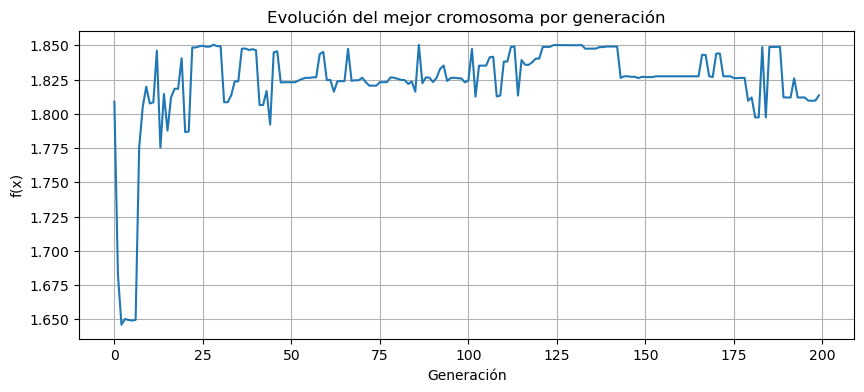

In [7]:
import numpy as np
import random
import matplotlib.pyplot as plt

# ---------- Parámetros del AG ----------
l = 16         # Longitud del cromosoma en bits. Más bits → más precisión en x
K = 50         # Tamaño de la población (número de cromosomas por generación)
M = 200        # Número de generaciones a ejecutar
p_mut = 0.01   # Probabilidad de mutación por gen
xi, xf = 0, 1  # Intervalo del dominio del problema x ∈ [0,1]

# ---------- Función objetivo ----------
def f(x):
    # La función a maximizar es f(x) = x * sin(10*pi*x) + 1
    return x * np.sin(10*np.pi*x) + 1

# ---------- Decodificación binaria → real ----------
def decodifica(crom):
    # Convierte un cromosoma (lista de bits) en un número real entre xi y xf
    valorDecimal = sum([crom[i]*2**(l-i-1) for i in range(l)])
    # Escalamiento lineal del valor binario al intervalo [xi, xf]
    return xi + (xf - xi) * valorDecimal / (2**l - 1)

# ---------- Evaluación de aptitud ----------
def evalua(crom):
    # Decodificamos el cromosoma y evaluamos f(x) para medir su aptitud
    x = decodifica(crom)
    return f(x)  # Maximización directa

# ---------- Generar población inicial ----------
def genera_poblacion():
    # Crea una lista con K cromosomas, cada uno con l bits aleatorios {0,1}
    return [np.random.randint(0, 2, l).tolist() for _ in range(K)]

# ---------- Selección por ruleta ----------
def seleccion(poblacion, aptitudes):
    # Selecciona padres proporcionalmente a su aptitud (los mejores tienen más probabilidad)
    total = sum(aptitudes)
    if total == 0: total = 1e-6  # Evitar división por cero
    probs = [apt/total for apt in aptitudes]
    # random.choices selecciona con reemplazo, manteniendo el tamaño K
    return random.choices(poblacion, weights=probs, k=K)

# ---------- Cruce en un punto ----------
def cruce(p1, p2):
    # Se elige un punto aleatorio y se intercambian las mitades para generar 2 hijos
    pt = random.randint(1, l-1)
    h1 = p1[:pt] + p2[pt:]
    h2 = p2[:pt] + p1[pt:]
    return h1, h2

# ---------- Mutación ----------
def mutacion(crom):
    # Cada bit del cromosoma puede invertirse con probabilidad p_mut
    for i in range(l):
        if random.random() < p_mut:
            crom[i] = 1 - crom[i]  # Si era 0 → 1, si era 1 → 0
    return crom

# ---------- Algoritmo Genético Principal ----------
poblacion = genera_poblacion()  # 1) Inicializamos población aleatoria
mejores = []  # Para guardar el mejor valor por generación

for gen in range(M):
    # 2) Evaluación de la población
    aptitudes = [evalua(c) for c in poblacion]
    mejor_idx = np.argmax(aptitudes)
    mejores.append(aptitudes[mejor_idx])  # Guardamos el mejor de esta generación
    
    # 3) Selección de padres (ruleta)
    padres = seleccion(poblacion, aptitudes)
    
    # 4) Cruce y mutación para generar nueva población
    nueva_poblacion = []
    for i in range(0, K, 2):
        h1, h2 = cruce(padres[i], padres[(i+1) % K])  # Cruce en un punto
        nueva_poblacion.append(mutacion(h1))  # Mutación de hijo1
        nueva_poblacion.append(mutacion(h2))  # Mutación de hijo2
    
    # 5) Reemplazamos la población anterior por la nueva
    poblacion = nueva_poblacion

# ---------- Resultados finales ----------
aptitudes_finales = [evalua(c) for c in poblacion]
mejor_idx = np.argmax(aptitudes_finales)
mejor_crom = poblacion[mejor_idx]
x_star = decodifica(mejor_crom)
f_star = f(x_star)

print(f"Máximo aproximado: x* = {x_star:.6f}, f(x*) = {f_star:.6f}")

# ---------- Gráfica de la función con el máximo ----------
x = np.linspace(0,1,1000)
plt.figure(figsize=(10,4))
plt.plot(x, f(x), label="f(x)")
plt.axvline(x_star, color="r", linestyle="--", label=f"x* ≈ {x_star:.4f}")
plt.title("Maximización con Algoritmo Genético")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend()
plt.grid(True)
plt.show()

# ---------- Evolución del mejor cromosoma ----------
plt.figure(figsize=(10,4))
plt.plot(mejores)
plt.title("Evolución del mejor cromosoma por generación")
plt.xlabel("Generación")
plt.ylabel("f(x)")
plt.grid(True)
plt.show()


Cuando se trata el asunto de optimizar la función 
Con el propósito de implementar un Algoritmo Genético (AG) conforme a la metodología del texto, elegí la función f(x)=xsin(10πx)+1 en el intervalo [0,1]. No solo se buscaba hallar el máximo, sino también entender cómo un proceso puede aproximarse a la solución de un problema de optimización que, en teoría, podría resolverse por medio de determinismo.


Como primer paso, definí la codificación binaria de las soluciones, en donde cada valor x es expresado como una secuencia de bits. dado que a más bits, la resolución en la búsqueda es mayor.

Después, definí la función de aptitud como f(x) con el fin de maximizarla directamente. Desde entonces, apliqué los tres operadores principales de los AG:

En la parte de la selección por ruleta: los cromosomas con mayor aptitud tienen más probabilidad de ser padres, asegurando que la información genética favorable pase a la siguiente generación.

Cruce en un punto: combiné aleatoriamente los cromosomas seleccionados para crear descendientes, permitiendo explorar nuevas regiones del espacio de búsqueda.

Mutación aleatoria: con baja probabilidad, invertí algunos bits para introducir diversidad y evitar quedar atrapado en óptimos locales.

La evolución se repitió durante varias generaciones y registré el mejor valor en cada una. Al final, el algoritmo encontró un 𝑥∗ que maximiza f(x) con una buena aproximación, mostrando además cómo la aptitud mejora progresivamente con cada generación.

En la sección de selección por ruleta: Los cromosomas más aptos tienen más probabilidades de ser progenitores, garantizando así que la información genética positiva se transmita a la próxima generación.

Cruce en un punto: hice una combinación aleatoria de los cromosomas seleccionados para generar descendencia, lo que permitió la exploración de nuevas áreas del espacio de búsqueda.


Mutación aleatoria: Para prevenir caer en óptimos locales, con baja probabilidad cambié algunos bits para incorporar diversidad.

A lo largo de numerosas generaciones, se repitió la evolución y registré el valor más alto en cada una de ellas. El algoritmo, al final, halló un 𝑥∗ que maximiza f(x) con una aproximación apropiada y muestra también cómo la aptitud se incrementa de manera gradual con cada generación.